<h1>SRCNN - Face Upscailing</h1>

Reference 1: https://kevinitcoding.tistory.com/entry/%EB%85%BC%EB%AC%B8-%EA%B5%AC%ED%98%84-SRCNNby-Pytorch%EC%9D%84-%ED%99%9C%EC%9A%A9%ED%95%9C-Super-Resolution#google_vignette  

Reference 2: https://mole-starseeker.tistory.com/82

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.dataloader import Dataset, DataLoader
from torchvision import transforms

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. Load dataset
https://huggingface.co/datasets/korexyz/celeba-hq-256x256

In [ ]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

data = load_dataset("korexyz/celeba-hq-256x256")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/989 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/461M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/28000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# 데이터셋 나누기 (80% train, 10% val, 10% test)
dataset = data["train"].train_test_split(test_size=0.99, seed=42) # 8:2
test_val = dataset["test"].train_test_split(test_size=0.5, seed=42) # 2 -> 1:1

# 최종 분할
dataset = {
    "train": dataset["train"],
    "val": test_val["train"],
    "test": test_val["test"]
}

# 데이터셋 크기 확인
print({split: len(data) for split, data in dataset.items()})

{'train': 280, 'val': 13860, 'test': 13860}


## 2. 저해상도 이미지 만들기(practice)

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256 at 0x7ADB0BACECD0>, 'label': 0}


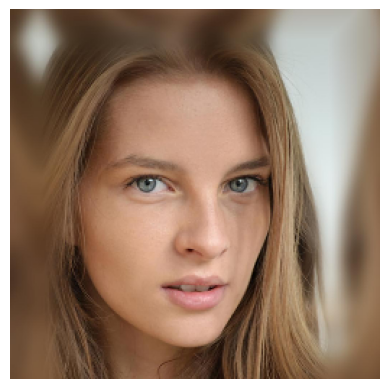

In [ ]:
first_data = dataset["train"][0]
print(first_data) # 256*256

first_img = first_data["image"]
plt.imshow(first_img)
plt.axis("off")  # 축 숨기기
plt.show()

In [ ]:
# mod_crop: 이미지의 비율을 유지하면서 특정 크기로 이미지를 자르도록 하기 위해서 이미지 크기 조정
# PIL 이미지를 numpy 배열로 변환
first_img_np = np.array(first_img)

# 원본 이미지 크기 출력
print("원본 이미지 크기:", first_img_np.shape)  # (height, width, channel)

# 현재 높이와 너비
h, w = first_img_np.shape[:2]

# upscale_factor로 나누어떨어지도록 크기 조정
up_fac = 3
h = h - (h % up_fac) # 256 % 3 = 1
w = w - (w % up_fac)

# 이미지 crop (PIL 기준: (left, upper, right, lower))
first_img_cropped = first_img.crop((0, 0, w, h))
print(f'크롭된 이미지 크기: ({h}, {w}, {3})')

원본 이미지 크기: (256, 256, 3)
크롭된 이미지 크기: (255, 255, 3)


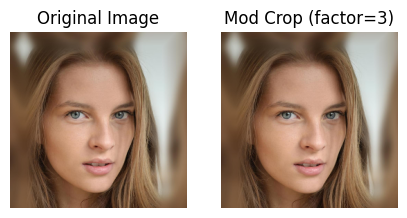

In [ ]:
# subplot을 사용하여 원본 이미지와 crop된 이미지 비교
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# 원본 이미지 출력
axes[0].imshow(first_img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Crop된 이미지 출력
axes[1].imshow(first_img_cropped)
axes[1].set_title(f"Mod Crop (factor={up_fac})")
axes[1].axis("off")

# 그래프 출력
plt.show()

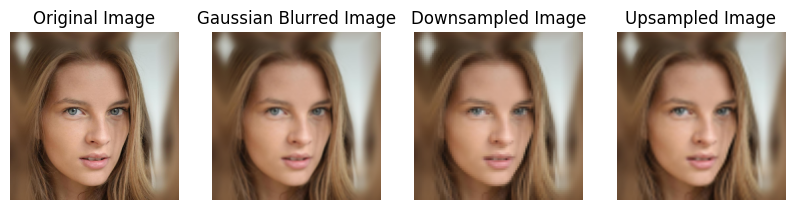

In [ ]:
# PIL 이미지를 numpy 배열로 변환
original_img = np.array(first_img_cropped)

# 블러 처리 (GaussianBlur 적용)
blurred_img = cv2.GaussianBlur(original_img, (5, 5), 0)

# 업스케일링 배율 설정
upscale_factor = 3

# 다운샘플링 (낮은 해상도로 변환)
h, w = blurred_img.shape[:2]
downsampled_img = cv2.resize(blurred_img, (w // upscale_factor, h // upscale_factor), interpolation=cv2.INTER_CUBIC)

# 업샘플링 (원본 크기로 복원)
upsampled_img = cv2.resize(downsampled_img, (w, h), interpolation=cv2.INTER_CUBIC)

# 이미지 출력
plt.figure(figsize=(10, 5))

# 첫 번째 subplot에 원본 이미지 추가
plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(blurred_img)
plt.title("Gaussian Blurred Image")
plt.axis("off")

# 두 번째 subplot에 다운샘플링된 이미지 추가
plt.subplot(1, 4, 3)
plt.imshow(downsampled_img)
plt.title("Downsampled Image")
plt.axis("off")

# 세 번째 subplot에 업샘플링된 이미지 추가
plt.subplot(1, 4, 4)
plt.imshow(upsampled_img)
plt.title("Upsampled Image")
plt.axis("off")


plt.show()

In [ ]:
sub_lr_imgs = []
in_size = 33
str = 14
for h in range(0, upsampled_img.shape[0] - in_size+1, str):
  for w in range(0, upsampled_img.shape[1] - in_size+1, str):
    sub_lr_img = upsampled_img[h:h+33, w:w+33, :] # 3번째 인자 :는 RGB 채널의 R,G,B 모두 포함한다는 뜻

    sub_lr_img = sub_lr_img.transpose(2,0,1) # pytorch에서 모델의 입력은 일반적으로 (C, H, W)

    sub_lr_imgs.append(sub_lr_img)


print(len(sub_lr_imgs)) # h:16 * w:16 = 256

sub_lr_imgs = torch.from_numpy(np.asarray(sub_lr_imgs)).float() # numpy 배열로 변환 후 tensor 변환: 연산 효율성, 일관성
print(sub_lr_imgs.shape)

256
torch.Size([256, 3, 33, 33])


## 2. 저해상도 이미지 만들기(execution)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, input_size, output_size, stride, upscale_factor, transform=None):
        """
        데이터셋을 초기화하는 함수.
        data: Huggingface Dataset 객체
        input_size: 입력 이미지 크기
        output_size: 출력 이미지 크기
        stride: 자르는 크기의 이동 간격
        upscale_factor: 저해상도 이미지 크기를 고해상도 크기로 변환할 비율
        transform: 데이터 변환 (예: augmentation)
        """
        super(CustomDataset, self).__init__()

        self.data = data
        self.stride = stride
        self.upscale_factor = upscale_factor
        self.sub_lr_imgs = [] # 저해상도 sub_image list
        self.sub_hr_imgs = [] # 고해상도 sub_image list

        self.input_size = input_size
        self.output_size = output_size
        self.pad = abs(self.input_size - self.output_size) // 2 # (33-19)//2: 양쪽에 7씩 패딩

        self.transform = transform

        print(f"Start {len(self.data)} Image Pre-Processing")  # 데이터셋 크기 출력

        for img in self.data['image']:  # 이미지 경로가 아닌 PIL 이미지 처리
            # mod_crop: 이미지 비율을 유지하면서 upscale_factor에 맞춰 자르기
            h = img.height - np.mod(img.height, self.upscale_factor)
            w = img.width - np.mod(img.width, self.upscale_factor)
            img = img.crop((0, 0, w, h))  # 왼쪽 위 (0, 0)에서 오른쪽 아래 (w, h)까지 자르기

            # Make LR (low resolution) Image
            label = np.array(img).astype(np.float32) / 255.0  # 0~1로 정규화
            blurred = cv2.GaussianBlur(label, (5, 5), 0)  # 가우시안 블러 적용
            temp_input = cv2.resize(blurred, dsize=(0, 0), fx=1 / self.upscale_factor, fy=1 / self.upscale_factor,
                                    interpolation=cv2.INTER_AREA)
            input = cv2.resize(temp_input, dsize=(0, 0), fx=self.upscale_factor, fy=self.upscale_factor,
                               interpolation=cv2.INTER_CUBIC)

            # Crop: 이미지를 여러 개의 작은 sub-image로 나누기
            for h in range(0, input.shape[0] - self.input_size + 1, self.stride):
                for w in range(0, input.shape[1] - self.input_size + 1, self.stride):
                    sub_lr_img = input[h:h + self.input_size, w:w + self.input_size, :] # 0:33, 0: 33
                    sub_hr_img = label[h + self.pad:h + self.pad + self.output_size, w + self.pad:w + self.pad + self.output_size, :] # 7:26, 7:26

                    sub_lr_img = sub_lr_img.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W)
                    sub_hr_img = sub_hr_img.transpose((2, 0, 1))

                    self.sub_lr_imgs.append(sub_lr_img)
                    self.sub_hr_imgs.append(sub_hr_img)
            print(f"Finish, Created {len(self.sub_lr_imgs)} Sub-Images")

        # List -> NumPy → Tensor 변환 (효율적으로)
        self.sub_lr_imgs = torch.from_numpy(np.asarray(self.sub_lr_imgs)).float()
        self.sub_hr_imgs = torch.from_numpy(np.asarray(self.sub_hr_imgs)).float()

    def __len__(self):
        return len(self.sub_lr_imgs)

    def __getitem__(self, idx):
        lr_img = self.sub_lr_imgs[idx]
        hr_img = self.sub_hr_imgs[idx]

        if self.transform is not None:
            lr_img = self.transform(lr_img)
            hr_img = self.transform(hr_img)

        return lr_img, hr_img

## 3. 파라미터 선언

In [ ]:
n1, n2, n3 = 128, 64, 3  # 각 conv_layer의 filter 개수, n3=3인 이유는 3차원 이미지 RGB 그대로 사용
f1, f2, f3 = 9, 3, 5  # 필터 크기: 9x9, 3x3, 5x5
stride = 14
upscale_factor = 3  # 저해상도 이미지를 3배로 확대

# 고해상도 이미지 크기 (256x256) 기준
input_size = 33
output_size = input_size - f1 - f2 - f3 + 3  # output = {(input - filter size + 2*padding) / stride} + 1

# 모델 학습 관련 설정
batch_size = 128
epochs = 200

# 데이터 및 모델 저장 경로 설정
path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/data/CelebA-HQ-img'  # 고해상도 이미지 데이터 경로
save_path = "/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/torch_SRCNN_face_100EPOCH.pth"  # 모델 저장 경로

# 파라미터 출력
print(f"Input size (low-resolution): {input_size}x{input_size}")
print(f"Output size (after convolution): {output_size}x{output_size}")

Input size (low-resolution): 33x33
Output size (after convolution): 19x19


## 4. Create Paired Dataset(LR-HR)

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# (256 - 33) // 14 + 1 = 16 -> 16*16 = 256(이미지 하나당 sub image 개수) -> 256*280 = 71680
train_dataset = CustomDataset(dataset['train'], input_size=input_size, output_size=output_size,
                              stride=stride, upscale_factor=upscale_factor, transform=transform)

Start 280 Image Pre-Processing
Finish, Created 256 Sub-Images
Finish, Created 512 Sub-Images
Finish, Created 768 Sub-Images
Finish, Created 1024 Sub-Images
Finish, Created 1280 Sub-Images
Finish, Created 1536 Sub-Images
Finish, Created 1792 Sub-Images
Finish, Created 2048 Sub-Images
Finish, Created 2304 Sub-Images
Finish, Created 2560 Sub-Images
Finish, Created 2816 Sub-Images
Finish, Created 3072 Sub-Images
Finish, Created 3328 Sub-Images
Finish, Created 3584 Sub-Images
Finish, Created 3840 Sub-Images
Finish, Created 4096 Sub-Images
Finish, Created 4352 Sub-Images
Finish, Created 4608 Sub-Images
Finish, Created 4864 Sub-Images
Finish, Created 5120 Sub-Images
Finish, Created 5376 Sub-Images
Finish, Created 5632 Sub-Images
Finish, Created 5888 Sub-Images
Finish, Created 6144 Sub-Images
Finish, Created 6400 Sub-Images
Finish, Created 6656 Sub-Images
Finish, Created 6912 Sub-Images
Finish, Created 7168 Sub-Images
Finish, Created 7424 Sub-Images
Finish, Created 7680 Sub-Images
Finish, Crea

In [ ]:
print(len(train_dataset))  # 데이터셋 크기 출력
lr_img, hr_img = train_dataset[0]  # 첫 번째 샘플 가져오기
print(type(lr_img), type(hr_img))  # torch.Tensor 타입인지 확인
print(lr_img.shape, hr_img.shape)  # 텐서 크기 확인

71680
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 33, 33]) torch.Size([3, 19, 19])


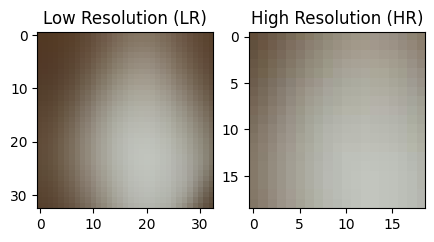

In [ ]:
# 데이터셋에서 첫 번째 샘플 가져오기
lr_img, hr_img = train_dataset[0]

# PyTorch 텐서는 (C, H, W)이므로 (H, W, C)로 변환
lr_img = lr_img.permute(1, 2, 0).numpy()
hr_img = hr_img.permute(1, 2, 0).numpy()

# 이미지 값이 [-1, 1] 범위이므로 다시 [0,1] 범위로 변환
lr_img = (lr_img * 0.5) + 0.5
hr_img = (hr_img * 0.5) + 0.5

# 저해상도 이미지 (LR) & 고해상도 이미지 (HR) 쌍 출력
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs[0].imshow(lr_img)
axs[0].set_title("Low Resolution (LR)")
#axs[0].axis("off")

axs[1].imshow(hr_img) # h, w -> [7:26, 7:26] -> 나중에 크기 7의 padding을 통해 33*33으로 맞춤
axs[1].set_title("High Resolution (HR)")
#axs[1].axis("off")

plt.show()

## 5. SRCNN Model 선언

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, kernel_list, filters_list, num_channels=3):
        super(SRCNN, self).__init__()

        f1, f2, f3 = kernel_list
        n1, n2, n3 = filters_list

        # padding을 'same'으로 맞추기 위해 (kernel_size // 2) 설정
        self.conv1 = nn.Conv2d(num_channels, n1, kernel_size=f1, padding=f1 // 2)
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=f2, padding=f2 // 2)
        self.conv3 = nn.Conv2d(n2, num_channels, kernel_size=f3, padding=f3 // 2)
        self.relu = nn.ReLU(inplace=True)

        # Xavier 초기화
        torch.nn.init.xavier_normal_(self.conv1.weight)
        torch.nn.init.xavier_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.conv3.weight)

        torch.nn.init.zeros_(self.conv1.bias)
        torch.nn.init.zeros_(self.conv2.bias)
        torch.nn.init.zeros_(self.conv3.bias)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [ ]:
#train/test loop

def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%100 == 0:
      loss, current = loss.item(), (batch+1)*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size=len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = 0

  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X=X.to(device)
      y=y.to(device)

      pred = model(X)
      test_loss += loss_fn(pred, y)
  test_loss /= num_batches
  print(f"Avg loss: {test_loss:>8f} \n")

In [ ]:
#Model Compile

model = SRCNN(kernel_list=[f1,f2,f3], filters_list=[n1,n2,n3]).to(device) # Pass a list and call to() method correctly
print(model)

params= model.parameters()
optimizer = optim.Adam(params=params, lr=1e-3)
loss_fn = nn.MSELoss()

SRCNN(
  (conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#Model training
for i in range(epochs):
  print("{} Epochs...".format(i+1))
  model.train()
  train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

torch.save(model.state_dict(), save_path)

1 Epochs...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128, 3, 19, 19])) that is different to the input size (torch.Size([128, 3, 33, 33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (33) must match the size of tensor b (19) at non-singleton dimension 3

In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/임은석.jpeg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = myface_img.transpose(2, 0, 1)  # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32)  # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img2 = srcnn_img.squeeze().cpu().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

Original img shape: (286, 225, 3)
Cropped img shape: (285, 225, 3)


<ipython-input-22-fb11dce3c7b1>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


myface_img.shape: (285, 225, 3)
srcnn_img2.shape: (285, 225, 3)


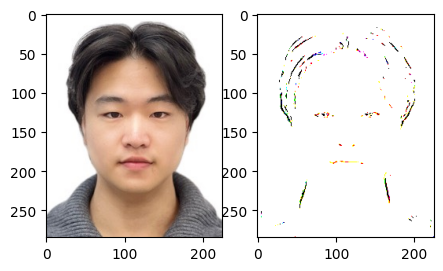

In [ ]:
# 결과 확인
print(f'myface_img.shape: {myface_img.shape}')
print(f'srcnn_img2.shape: {srcnn_img2.shape}')

fig, axes = plt.subplots(1, 2, figsize=(5,5))

axes[0].imshow(myface_img)
axes[1].imshow(srcnn_img2)

plt.show()

Original img shape: (286, 225, 3)
Cropped img shape: (285, 225, 3)


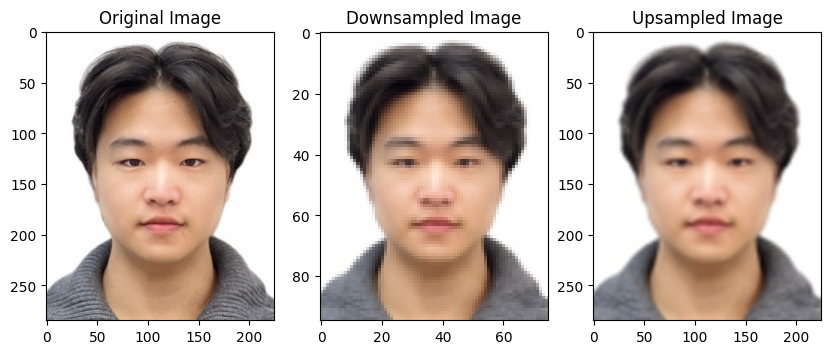

In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/임은석.jpeg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(10,5))

axes[0].imshow(myface_img)
axes[1].imshow(temp_img)
axes[2].imshow(bicubic_img)

axes[0].set_title("Original Image")
axes[1].set_title("Downsampled Image")
axes[2].set_title("Upsampled Image")

plt.show()

In [ ]:
# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

<ipython-input-69-3c4fdae7ee4d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


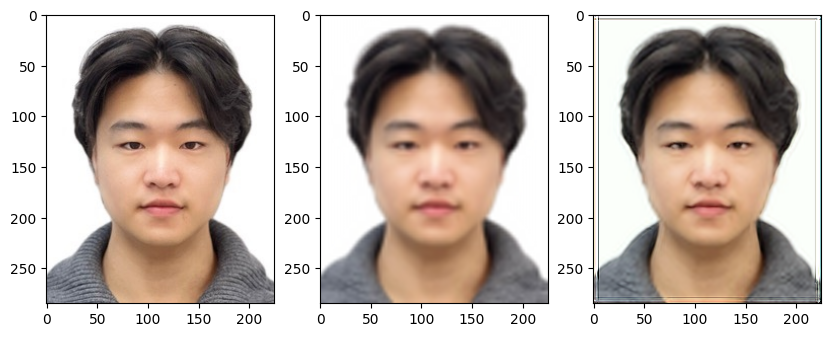

In [ ]:
# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(10,5))

axes[0].imshow(myface_img)
axes[1].imshow(bicubic_img)
axes[2].imshow(np.squeeze(srcnn_img))

plt.show()

In [ ]:
#def PSNR(y_pred, y_true):
#  return 10.*torch.log10(1./torch.mean((y_pred-y_true)**2))

import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def PSNR(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio (PSNR) for RGB images"""
    if isinstance(img1, np.ndarray):
        img1 = torch.tensor(img1, dtype=torch.float32)
    if isinstance(img2, np.ndarray):
        img2 = torch.tensor(img2, dtype=torch.float32)

    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def SSIM(img1, img2):
    """Calculate Structural Similarity Index (SSIM) for RGB images"""
    # Convert torch.Tensor to numpy if necessary
    if isinstance(img1, torch.Tensor):
        img1 = img1.cpu().numpy()
    if isinstance(img2, torch.Tensor):
        img2 = img2.cpu().numpy()

    # Ensure image range is between 0 and 1
    img1 = np.clip(img1, 0, 1)
    img2 = np.clip(img2, 0, 1)

    return ssim(img1, img2, channel_axis=-1, data_range=1.0)

# PSNR & SSIM 계산
psnr_value = PSNR(srcnn_img, myface_img)
ssim_value = SSIM(srcnn_img, myface_img)

print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

PSNR: 22.37 dB
SSIM: 0.8399


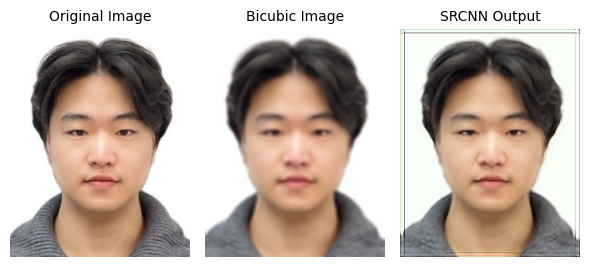

In [ ]:
# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import lpips
import numpy as np
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# LPIPS 모델 로드 (VGG 기반)
lpips_loss = lpips.LPIPS(net='vgg').to(device)

# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth
PSNR: 22.37 dB
SSIM: 0.8330
LPIPS: 0.2105


Original img shape: (1024, 1024, 3)
Cropped img shape: (1023, 1023, 3)


<ipython-input-87-3e11c09cf8f5>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


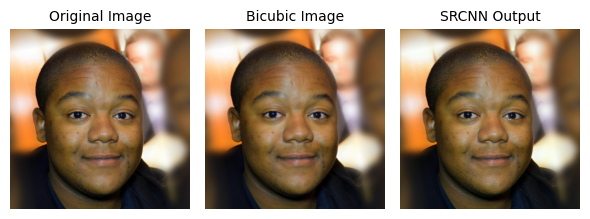

In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/train-00000-of-00006_2.jpg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)


# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

PSNR: 32.83 dB
SSIM: 0.9355
LPIPS: 0.1565


Original img shape: (1024, 1024, 3)
Cropped img shape: (1023, 1023, 3)


<ipython-input-89-a9f63f5e3001>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


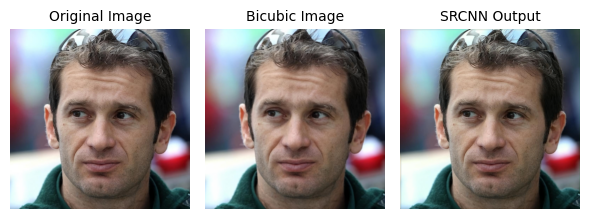

PSNR: 30.89 dB
SSIM: 0.9640
LPIPS: 0.0843


In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/train-00000-of-00006_6.jpg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)


# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

Original img shape: (1024, 1024, 3)
Cropped img shape: (1023, 1023, 3)


<ipython-input-90-e24e2fa5fbbb>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


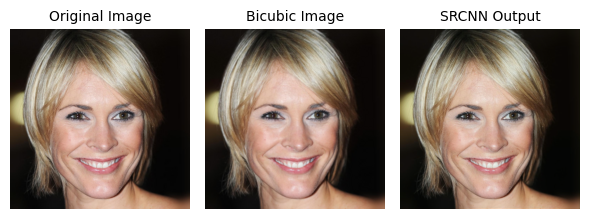

PSNR: 32.73 dB
SSIM: 0.9053
LPIPS: 0.1589


In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/train-00000-of-00006_15.jpg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)


# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

Original img shape: (1024, 1024, 3)
Cropped img shape: (1023, 1023, 3)


<ipython-input-92-adc1fc3dd01e>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


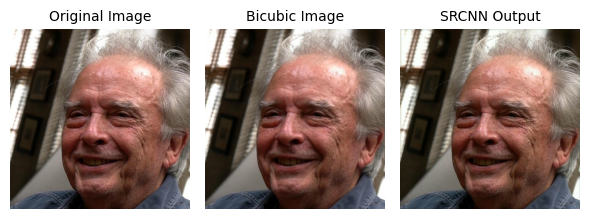

PSNR: 31.02 dB
SSIM: 0.9574
LPIPS: 0.1024


In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/train-00000-of-00006_22.jpg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)


# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")

Original img shape: (1024, 1024, 3)
Cropped img shape: (1023, 1023, 3)


<ipython-input-93-e258b5ea8392>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


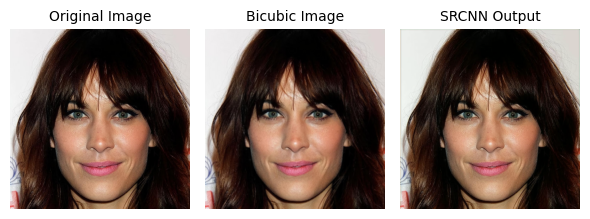

PSNR: 28.85 dB
SSIM: 0.9145
LPIPS: 0.1310


In [ ]:
# HR 이미지 경로
myface_img_path = '/content/drive/MyDrive/Colab Notebooks/BITAmin/CV_SR/train-00000-of-00006_27.jpg'

# 이미지 읽기 및 변환
myface_img = cv2.imread(myface_img_path)
myface_img = cv2.cvtColor(myface_img, cv2.COLOR_BGR2RGB)
print("Original img shape: {}".format(myface_img.shape))

# mod_crop (upscale_factor로 나누어떨어지도록 크기 조정)
h, w = myface_img.shape[:2]
upscale_fac = 3

h = h - (h % upscale_fac)
w = w - (w % upscale_fac)
myface_img = myface_img[:h, :w]
print("Cropped img shape: {}".format(myface_img.shape))

# 저해상도 이미지 만들기
myface_img = myface_img.astype(np.float32) / 255.0
blurred_img = cv2.GaussianBlur(myface_img, (5, 5), 0)
temp_img = cv2.resize(blurred_img, (w // upscale_fac, h // upscale_fac), interpolation=cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, (w, h), interpolation=cv2.INTER_CUBIC)


# 모델 로드 (state_dict 로딩)
model = SRCNN(kernel_list=[f1, f2, f3], filters_list=[n1, n2, n3]).to(device)
model.load_state_dict(torch.load(save_path))
model.eval()

# 입력 이미지 변환
input_img = bicubic_img.transpose(2,0,1) # (H, W, C) → (C, H, W)
input_img = torch.from_numpy(input_img).unsqueeze(0).to(device, dtype=torch.float32) # 배치 차원 추가

# 모델 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 출력 이미지 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose(1,2,0)  # (C, H, W) → (H, W, C)

# 결과 확인
fig, axes = plt.subplots(1, 3, figsize=(6, 4))

# 축 없애기
for ax in axes:
    ax.axis('off')

# 이미지 출력 및 제목 설정
axes[0].imshow(myface_img)
axes[0].set_title("Original Image", fontsize=10)

axes[1].imshow(bicubic_img)
axes[1].set_title("Bicubic Image", fontsize=10)

axes[2].imshow(np.squeeze(srcnn_img))
axes[2].set_title("SRCNN Output", fontsize=10)

plt.tight_layout()
plt.show()

# PSNR 계산
psnr_value = psnr(myface_img, srcnn_img, data_range=1)

# SSIM 계산 (각 채널별로 평균)
ssim_value = ssim(myface_img, srcnn_img, data_range=1, channel_axis=2)

# LPIPS 계산 (Tensor 변환 필요)
transform = transforms.ToTensor()
myface_tensor = transform(myface_img).unsqueeze(0).to(device)
srcnn_tensor = transform(srcnn_img).unsqueeze(0).to(device)

lpips_value = lpips_loss(myface_tensor, srcnn_tensor).item()

# 결과 출력
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")
print(f"LPIPS: {lpips_value:.4f}")